# U-net Image Segmentation


 <br>So, U-Net is an architecture for semantic segmentation. It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.
--- 
The network Architecture 
<img src = 'https://paperswithcode.com/media/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png'>


- So this U-net Architecture divided into two sides , the left side for encoding the input and right side is decoding

- An excellent explation of U-Net Architecture 
[Explation of U-Net](https://youtu.be/azM57JuQpQI?list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE)

- [Paper: U-Net: Convolutional Networks for BiomedicalImage Segmentation](https://arxiv.org/abs/1505.04597)


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [6]:
import tensorflow as tf
import os
import random 
import numpy as np
from tqdm import tqdm

from zipfile import ZipFile 

from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [7]:
# The input image will be 128 * 128
# And the Channels will be 3

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [8]:
# specifying the zip file name
TRAIN_Name='../input/data-science-bowl-2018/stage1_train.zip'
TEST_Name ='../input/data-science-bowl-2018/stage1_test.zip'
TRAIN_PATH="stage1_train/"
TEST_PATH='stage1_test/'

In [9]:
# Opening the train Zip file in Read Mode
with ZipFile(TRAIN_Name , 'r') as zip:
    print("Extracting from zip file")
    zip.extractall("stage1_train") 
    print('Done!') 
    
# Opening the test Zip file in Read Mode
with ZipFile(TEST_Name , 'r') as zip:
    print("Extracting from zip file")
    zip.extractall("stage1_test") 
    print('Done!') 

    

Extracting from zip file
Done!
Extracting from zip file
Done!


In [11]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [12]:
# Create an array of same image dimension
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [13]:
print(f'X_train Shape : {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'train_ids : {len(train_ids)}')
print(f'test_ids : {len(test_ids)}')

X_train Shape : (670, 128, 128, 3)
Y_train shape: (670, 128, 128, 1)
train_ids : 670
test_ids : 65


In [15]:
print('Resizing training images and masks')
#For training images
for n , id_ , in tqdm(enumerate(train_ids) , total = len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    X_train[n] = img ##Fill empty X_train with values from img
    
    mask = np.zeros((IMG_HEIGHT , IMG_WIDTH,1),dtype = np.bool)
    for mask_file in next(os.walk(path + '/masks'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask

  0%|          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


100%|██████████| 670/670 [07:00<00:00,  1.60it/s]


In [16]:
print('Resizing test images')
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

  6%|▌         | 4/65 [00:00<00:02, 24.93it/s]

Resizing test images
Resizing test images


100%|██████████| 65/65 [00:02<00:00, 26.98it/s]

Done!


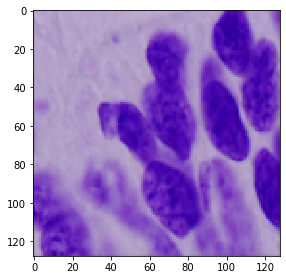

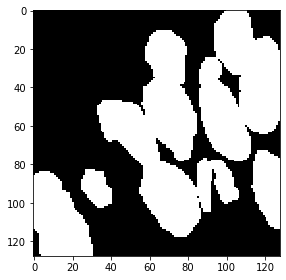

In [17]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()


In [18]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#Build the path
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = 'relu',kernel_initializer = 'he_normal',padding ='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [19]:
#Modelcheckpoint https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 59s 1s/step - loss: 0.7109 - accuracy: 0.8026 - val_loss: 0.3992 - val_accuracy: 0.8112
Epoch 2/25
38/38 [==============================] - 56s 1s/step - loss: 0.3132 - accuracy: 0.8499 - val_loss: 0.2277 - val_accuracy: 0.9121
Epoch 3/25
38/38 [==============================] - 55s 1s/step - loss: 0.1889 - accuracy: 0.9285 - val_loss: 0.1676 - val_accuracy: 0.9344
Epoch 4/25
38/38 [==============================] - 56s 1s/step - loss: 0.1571 - accuracy: 0.9389 - val_loss: 0.1332 - val_accuracy: 0.9462
Epoch 5/25
38/38 [==============================] - 56s 1s/step - loss: 0.1291 - accuracy: 0.9507 - val_loss: 0.1228 - val_accuracy: 0.9520
Epoch 6/25
38/38 [==============================] - 61s 2s/step - loss: 0.1198 - accuracy: 0.9540 - val_loss: 0.1192 - val_accuracy: 0.9528
Epoch 7/25
38/38 [==============================] - 56s 1s/step - loss: 0.1131 - accuracy: 0.9564 - val_loss: 0.1058 - val_accuracy: 0.9586
Epoch 8/25
38/38 [==

In [20]:
seed=40
np.random.seed=seed

In [21]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 323ms/step


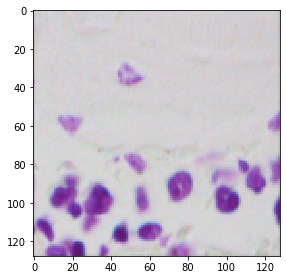

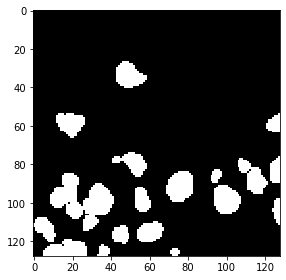

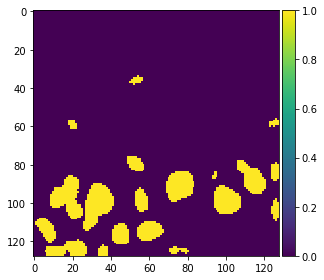

In [23]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

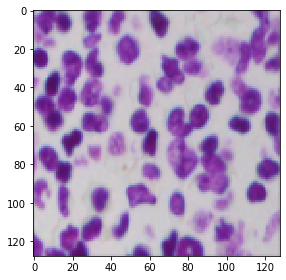

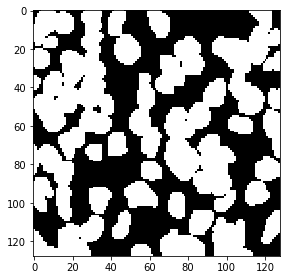

/opt/conda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


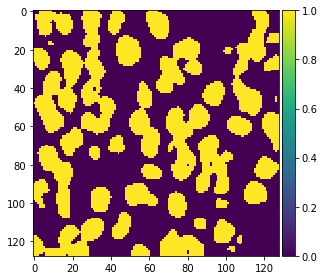

In [22]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [24]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

import numpy as np

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.4.1


In [25]:
data_size = 1000
# 80% of the data is for training.
train_pct = 0.8

train_size = int(data_size * train_pct)

# Create some input data between -1 and 1 and randomize it.
x = np.linspace(-1, 1, data_size)
np.random.shuffle(x)

# Generate the output data.
# y = 0.5x + 2 + noise
y = 0.5 * x + 2 + np.random.normal(0, 0.05, (data_size, ))

# Split into test and train pairs.
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]


In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = keras.models.Sequential([
    keras.layers.Dense(16, input_dim=1),
    keras.layers.Dense(1),
])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=keras.optimizers.SGD(lr=0.2),
)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = model.fit(
    x_train, # input
    y_train, # output
    batch_size=train_size,
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))